### 1. Install necessary libraries (if not installed)

In [1]:
!pip install datasets transformers biopython torch scikit-learn pandas matplotlib

### 1.1 Upload .soft file

In [2]:
import pandas as pd
from google.colab import files

print("Please upload your .soft file.")
uploaded = files.upload()

for file_name in uploaded.keys():
    file_path = file_name  # The uploaded file's name
    print(f"File {file_name} uploaded successfully.")

    # Load the .soft file
    try:
        # Read the .soft file
        df = pd.read_csv(file_path, sep='\t', comment='!', header=0)  # .soft files may have metadata marked with '!'

        # Inspect the dataset
        print("Dataset loaded successfully!")
        print(df.head())

        # Handle missing values
        df.fillna("N/A", inplace=True)

        # Filter rows
        if 'GO:Function' in df.columns:
            filtered_df = df[df['GO:Function'].str.contains("GTP binding", na=False)]
            print("Filtered dataset based on 'GO:Function' containing 'GTP binding':")
            print(filtered_df.head())

        # Incorporate new columns in processing
        if 'Platform_SEQUENCE' in df.columns:
            df['Sequence_Length'] = df['Platform_SEQUENCE'].apply(len)

        # Save processed dataset as CSV
        processed_file_path = "processed_dataset.csv"
        df.to_csv(processed_file_path, index=False)

        print(f"Processed dataset saved to {processed_file_path}")

    except Exception as e:
        print(f"Error processing the file: {e}")

Please upload your .soft file.


Saving databank.soft to databank (1).soft
File databank (1).soft uploaded successfully.
Dataset loaded successfully!
         ID_REF    IDENTIFIER  GSM1684096  GSM1684098  GSM1684100  GSM1684102  \
0  ILMN_1343048  ILMN_1343048         NaN         NaN         NaN         NaN   
1  ILMN_1343049  ILMN_1343049         NaN         NaN         NaN         NaN   
2  ILMN_1343050  ILMN_1343050         NaN         NaN         NaN         NaN   
3  ILMN_1343052  ILMN_1343052         NaN         NaN         NaN         NaN   
4  ILMN_1343059  ILMN_1343059         NaN         NaN         NaN         NaN   

   GSM1684104  GSM1684095  GSM1684097  GSM1684099  ...  Platform_SPOTID  \
0         NaN         NaN         NaN         NaN  ...              NaN   
1         NaN         NaN         NaN         NaN  ...              NaN   
2         NaN         NaN         NaN         NaN  ...              NaN   
3         NaN         NaN         NaN         NaN  ...              NaN   
4         NaN        

<ipython-input-2-d27c30337077>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("N/A", inplace=True)


### 1.3 Import libraries

In [3]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification,  Trainer, TrainingArguments
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

### 1.4 Load the processed dataset

In [4]:
file_path = "processed_dataset.csv"
df = pd.read_csv(file_path, sep=',')

In [6]:
print(df.columns)

Index(['ID_REF', 'IDENTIFIER', 'GSM1684096', 'GSM1684098', 'GSM1684100',
       'GSM1684102', 'GSM1684104', 'GSM1684095', 'GSM1684097', 'GSM1684099',
       'GSM1684101', 'GSM1684103', 'Gene title', 'Gene symbol', 'Gene ID',
       'UniGene title', 'UniGene symbol', 'UniGene ID', 'Nucleotide Title',
       'GI', 'GenBank Accession', 'Platform_CLONEID', 'Platform_ORF',
       'Platform_SPOTID', 'Chromosome location', 'Chromosome annotation',
       'GO:Function', 'GO:Process', 'GO:Component', 'GO:Function ID',
       'GO:Process ID', 'GO:Component ID', 'Platform_SEQUENCE',
       'Sequence_Length'],
      dtype='object')


In [7]:
print(df[["GSM1684096", "GSM1684098", "GSM1684100"]].info())
print(df[["GSM1684096", "GSM1684098", "GSM1684100"]].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GSM1684096  2 non-null      float64
 1   GSM1684098  2 non-null      float64
 2   GSM1684100  2 non-null      float64
dtypes: float64(3)
memory usage: 4.8 KB
None
   GSM1684096  GSM1684098  GSM1684100
0         NaN         NaN         NaN
1         NaN         NaN         NaN
2         NaN         NaN         NaN
3         NaN         NaN         NaN
4         NaN         NaN         NaN
5         NaN         NaN         NaN
6         NaN         NaN         NaN
7         NaN         NaN         NaN
8         NaN         NaN         NaN
9     22303.3     24776.1     26775.3


### 2. Clean and preprocess the data

In [9]:
expression_columns = ["GSM1684096", "GSM1684098", "GSM1684100"]
df = df.dropna(subset=expression_columns, how='all')  # Drop rows where all are NaN
df["expression"] = df["GSM1684096"]
df["expression"] = pd.to_numeric(df["expression"], errors="coerce")
print(df["expression"].describe())
df = df.dropna(subset=["expression"])

count        2.000000
mean     15017.975000
std      10303.005421
min       7732.650000
25%      11375.312500
50%      15017.975000
75%      18660.637500
max      22303.300000
Name: expression, dtype: float64


In [15]:
df["sequence"] = df["Platform_SEQUENCE"]
print(df["sequence"].head())
print(df["sequence"].dtype)

9     TGTGTTGAGAGCTTCTCAGACTATCCACCTTTGGGTCGCTTTGCTG...
10    CTTCAACAGCGACACCCACTCCTCCACCTTTGACGCTGGGGCTGGC...
Name: sequence, dtype: object
object


### 2.1 Inspect the dataset

In [16]:
print(df.head())
print(df["expression"].dtype)  # dtype is float

          ID_REF IDENTIFIER  GSM1684096  GSM1684098  GSM1684100  GSM1684102  \
9   ILMN_1343291     EEF1A1    22303.30    24776.10    26775.30    25980.20   
10  ILMN_1343295      GAPDH     7732.65     5296.75     6430.16     4801.03   

    GSM1684104  GSM1684095  GSM1684097  GSM1684099  ...  \
9     26775.30    23599.30    25980.20    24776.10  ...   
10     5654.94     6405.33     6553.48     7699.22  ...   

                                          GO:Function  \
9   GTP binding///GTPase activity///poly(A) RNA bi...   
10  NAD binding///NADP binding///glyceraldehyde-3-...   

                                           GO:Process  \
9   cellular response to epidermal growth factor s...   
10  canonical glycolysis///cellular response to in...   

                                         GO:Component  \
9   cortical actin cytoskeleton///cytoplasm///cyto...   
10  GAIT complex///cytoplasm///cytoplasm///cytosol...   

                                       GO:Function ID  \
9   GO:0005

### 3. Covert DataFrame to a Hugging Face Dataset

In [17]:
dataset = Dataset.from_pandas(df)

In [18]:
print(df.dtypes)

ID_REF                    object
IDENTIFIER                object
GSM1684096               float64
GSM1684098               float64
GSM1684100               float64
GSM1684102               float64
GSM1684104               float64
GSM1684095               float64
GSM1684097               float64
GSM1684099               float64
GSM1684101               float64
GSM1684103               float64
Gene title                object
Gene symbol               object
Gene ID                  float64
UniGene title            float64
UniGene symbol           float64
UniGene ID               float64
Nucleotide Title          object
GI                       float64
GenBank Accession         object
Platform_CLONEID         float64
Platform_ORF             float64
Platform_SPOTID          float64
Chromosome location       object
Chromosome annotation     object
GO:Function               object
GO:Process                object
GO:Component              object
GO:Function ID            object
GO:Process

### 4. Initialize the tokenizer

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### 4.1 Tokenize the sequences

In [20]:
def tokenize_function(example):
    tokenized_output = tokenizer(
        example['sequence'],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    return {
        "input_ids": tokenized_output["input_ids"][0].tolist(),
        "attention_mask": tokenized_output["attention_mask"][0].tolist(),
        "labels": float(example["expression"]),  # labels are floats
    }

dataset = dataset.map(tokenize_function)

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

### 4.2 Verify

In [21]:
print(dataset[0])

{'ID_REF': 'ILMN_1343291', 'IDENTIFIER': 'EEF1A1', 'GSM1684096': 22303.3, 'GSM1684098': 24776.1, 'GSM1684100': 26775.3, 'GSM1684102': 25980.2, 'GSM1684104': 26775.3, 'GSM1684095': 23599.3, 'GSM1684097': 25980.2, 'GSM1684099': 24776.1, 'GSM1684101': 25980.2, 'GSM1684103': 23599.3, 'Gene title': 'eukaryotic translation elongation factor 1 alpha 1', 'Gene symbol': 'EEF1A1', 'Gene ID': 1915.0, 'UniGene title': None, 'UniGene symbol': None, 'UniGene ID': None, 'Nucleotide Title': 'Homo sapiens eukaryotic translation elongation factor 1 alpha 1 (EEF1A1), mRNA', 'GI': 83367078.0, 'GenBank Accession': 'NM_001402', 'Platform_CLONEID': None, 'Platform_ORF': None, 'Platform_SPOTID': None, 'Chromosome location': '6q14.1', 'Chromosome annotation': 'Chromosome 6, NC_000006.12 (73515750..73521032, complement)', 'GO:Function': 'GTP binding///GTPase activity///poly(A) RNA binding///protein binding///protein kinase binding///tRNA binding///translation elongation factor activity', 'GO:Process': 'cellular

### 5. Split into train and eval datasets (80-20 split)

In [22]:
train_dataset = dataset.shuffle(seed=42).select([i for i in range(int(0.8 * len(dataset)))])
eval_dataset = dataset.shuffle(seed=42).select([i for i in range(int(0.8 * len(dataset)), len(dataset))])

### 6. Load the pre-trained BERT model for regression

In [23]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 7. Set up training arguments

In [24]:
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    num_train_epochs=10,             # Number of training epochs
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Log directory
    report_to="none"                 # Disable wandb logging
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### 8. Set up the Trainer

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

### 9. Train the model

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,497413344.000000
2,No log,497406464.000000
3,No log,497397312.000000
4,No log,497390880.000000
5,No log,497385312.000000
6,No log,497380256.000000
7,No log,497375968.000000
8,No log,497373632.000000
9,No log,497371552.000000
10,No log,497370240.000000


TrainOutput(global_step=10, training_loss=59778656.0, metrics={'train_runtime': 113.909, 'train_samples_per_second': 0.088, 'train_steps_per_second': 0.088, 'total_flos': 2631086929920.0, 'train_loss': 59778656.0, 'epoch': 10.0})

### 10. Evaluate the model's performance (on the validation set)

In [27]:
predictions = trainer.predict(eval_dataset)

### 10.1 Extract true and predicted values

In [28]:
y_true = [example["labels"] for example in eval_dataset]
y_pred = predictions.predictions.flatten()

### 10.2 Calculate evaluation metrics (RMSE and MAE)

In [29]:
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 10.3 Print out the evaluation metrics

In [30]:
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 22301.797597694396
MAE: 22301.797597694396


### 11. True vs Predicted values

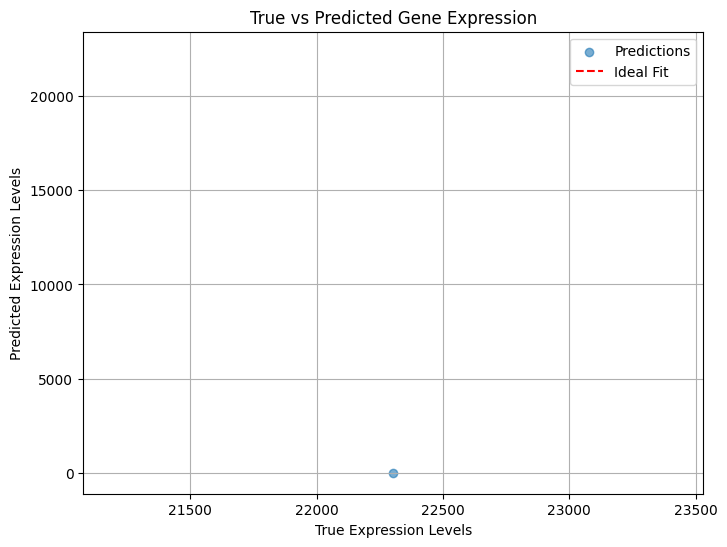

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.6, label="Predictions")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label="Ideal Fit")
plt.xlabel('True Expression Levels')
plt.ylabel('Predicted Expression Levels')
plt.title('True vs Predicted Gene Expression')
plt.legend()
plt.grid()
plt.show()

### 12. (EXTRA EVALUATION) Checking if the dataset isnt too or biased

In [32]:
print(df['expression'].describe())
print(df['expression'].unique())

count        2.000000
mean     15017.975000
std      10303.005421
min       7732.650000
25%      11375.312500
50%      15017.975000
75%      18660.637500
max      22303.300000
Name: expression, dtype: float64
[22303.3   7732.65]


### 12.1 (EXTRA EVALUATION) Inspect predictions

In [33]:
print("Predictions:", y_pred)
print("True Values:", y_true)

Predictions: [1.5024023]
True Values: [22303.3]


### 13. Saving the results

In [34]:
results_df = pd.DataFrame({
    "True Expression": y_true,
    "Predicted Expression": y_pred
})

results_df.to_csv("model_predictions.csv", index=False)
print("Predictions saved to model_predictions.csv")

Predictions saved to model_predictions.csv
